In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib as mpl
import ugradio

mpl.rcParams['axes.linewidth'] = 2 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

No module named 'rtlsdr'


# Load in Raw Data

In [38]:
sun_data = np.load("data/1hr_Sun_data.npy")
data = np.array([sun_data[1,:], sun_data[0,:]])
data = data[:,100:]

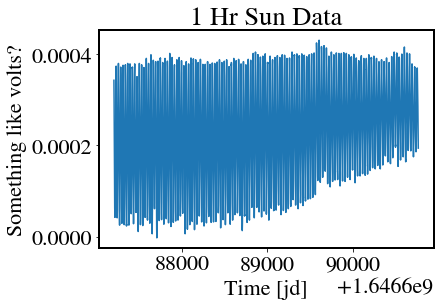

In [39]:
plt.plot(data[0], data[1])
plt.title("1 Hr Sun Data")
plt.xlabel("Time [jd]")
plt.ylabel("Something like volts?")
plt.show()

## $\chi^2$ Analysis

This is an argument inside the next equation. It depends on a whole bunch of stuff $(B_{ew}, B_{ns}, \delta, h_s)$ which we will define in the cell below. We are most interested in $B_{ew}, B_{ns}$, the frequency of the trig functions is

$$\nu \tau_g'(B_{ew}, B_{ns}, \delta, h_s) = \left[{B_{ew} \over \lambda} \cos \delta \right] \sin h_s 
  + \left[{B_{ns} \over \lambda} \sin L \cos \delta \right] \cos h_s$$


We need to explore parameter space by making a grid of $B_{ew}, B_{ns}$ and curve fitting at each combo to yield a $\chi^2$ value for each combination. We will be fitting for $A,B$ but we don't care about those at all. This will allow us to fit the fringe amplitude. As long as we stay within 1 bessel envelope node we should be fine, so the 1 hour data should be just fine.

$$F(h_s) = A \cos \left(2 \pi \nu \tau_g' \right) 
         +B \sin \left(2 \pi \nu \tau_g' \right)$$
         
 

In [40]:
# L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 
# λ = 2.5 / 100 # 2.5 cm

# jds = data[0] / 86400 + 2440587.5 #julian dates
# pos = np.array([[ugradio.coord.sunpos(jd)] for jd in jds]) #takes a long time to compute
# α,δ = pos[:, 0, 0], pos[:, 0, 1]

# LSTs = ugradio.timing.lst(jds) #feed in an array of julian dates observed.
# h_s = LSTs - α #create array of hour angles

# #in the mean time we create h_s just by a linspace
# h_s

import astropy.constants as con
import astropy.units as u

val = con.c / (10.5e9 * u.Hz)
λ = val.to(u.m).value

L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 
# λ = 2.77 / 100 # 2.77 cm

jds=ugradio.timing.julian_date(data[0])
α,δ =ugradio.coord.sunpos(jds[0])
δ=(np.pi/180)*δ

LSTs = ugradio.timing.lst(jds,lon=long) #feed in an array of julian dates observed.

# h_s = LSTs-α*(np.pi/180) 

In [41]:
h_s = np.linspace(11.02,(11.02+15),len(jds))*(np.pi/180) #h_s for 1hr sun data 
# h_s = np.linspace(-74.18,(-74.18+15*6),len(jds))*(np.pi/180) #h_s for 6hr sun data

In [42]:
#model functions
def ν_τg(h_s, B_ew, B_ns, δ, λ):
    return (((B_ew / λ) * np.cos(δ)) * np.sin(h_s) + ((B_ns / λ) * np.sin(L) * np.cos(δ)) * np.cos(h_s))

def fringe_model(ν_τg, A, B):
    return A * np.cos(2 * np.pi * ν_τg) + B * np.sin(2 * np.pi * ν_τg)
    

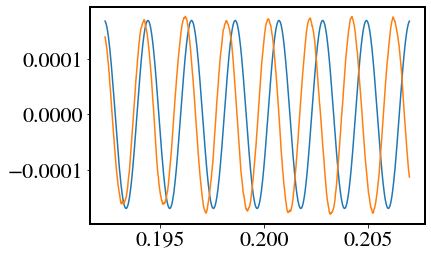

In [43]:
v = ν_τg(h_s[:1000], 14, 3, δ, λ)

plt.plot(h_s[:1000], fringe_model(v, 0.00012, 0.00012))
plt.plot(h_s[:1000],data[1][:1000]-np.mean(data[1][:1000]))
plt.show()

In [78]:
#create grid of baseline values
resolution = 100
xmin,xmax = 14.70,14.705
ymin,ymax = 3.225,3.28
B_ew, B_ns = np.linspace(xmin, xmax, resolution), np.linspace(ymin, ymax, resolution)
B_EW, B_NS = np.meshgrid(B_ew, B_ns)

### Compute $\chi^2$

Note: this is SLOW, reduce resolution to speed up

In [79]:
def compute_χ_sq(file_name):
    ydata = data[1] - np.mean(data[1])

    χ_sq = np.zeros(B_EW.shape)
    χ_sq_r = np.zeros(B_EW.shape)
    
    for i in range(len(B_ew)):
        for j in range(len(B_ns)):
            vs = ν_τg(h_s, B_EW[i,j], B_NS[i,j], δ, λ)  # Try new baselines
            p0 = np.array([0.0002,0.0003]) # A, B Guesses
            params, cov = scipy.optimize.curve_fit(fringe_model, vs, ydata, p0)
            chi_squared = np.sum(((fringe_model(vs, *params)-ydata)/.00001)**2)
            reduced_chi_squared = (chi_squared)/(len(vs)-len(params))
            χ_sq[i,j] = chi_squared
            χ_sq_r[i,j] = reduced_chi_squared
            
    np.save("data/chi_sq_" + file_name + ".npy", χ_sq)
    np.save("data/chi_sq_r_" + file_name + ".npy", χ_sq_r)
    
    return χ_sq, χ_sq_r

In [80]:
χ_sq, χ_sq_r = compute_χ_sq("1hr_sun_zoomed_in")

### Plot!

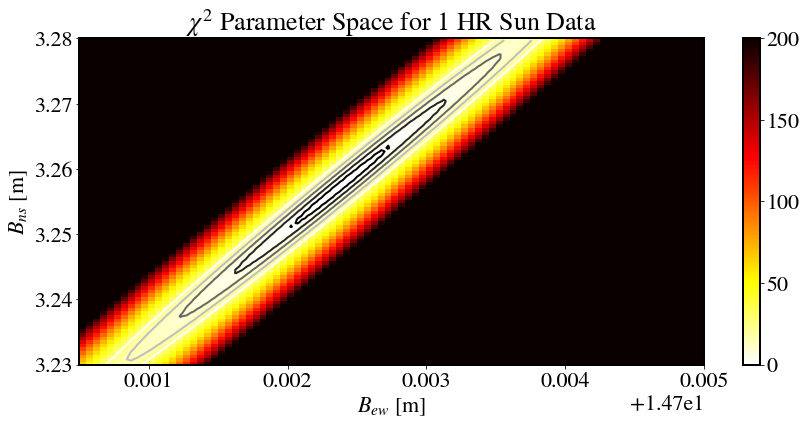

In [176]:
# χ_sq_R = np.load("data/chi_sq_r_6hr_sun.npy")

extent=[xmin, xmax, ymin, ymax]
levels = [1, 4, 9, 16, 25]
plt.figure(figsize=(14,6))
plt.title("$\chi^2$ Parameter Space for 1 HR Sun Data",fontsize=26)

plt.contour(χ_sq - np.min(χ_sq), levels, cmap="Greys_r", origin='lower',linewidths=2, extent=extent)
plt.imshow(χ_sq - np.min(χ_sq), origin="lower",extent=extent, cmap="hot_r", aspect="auto", vmax=200)
plt.xlabel("$B_{ew}$ [m]")
plt.ylabel("$B_{ns}$ [m]")
plt.ylim(3.23,3.28)
plt.xlim(14.7005,14.705)
plt.colorbar()

plt.show()

In [172]:
shifted = χ_sq - np.min(χ_sq) 

nσ = 3

xs = np.where(np.isclose(shifted, nσ**2, rtol=1e-2))[0][:]
ys = np.where(np.isclose(shifted, nσ**2, rtol=1e-2))[1][:]

max_B_ew, min_B_ew = np.max(B_EW[xs,ys]),np.min(B_EW[xs,ys])
max_B_ns, min_B_ns = np.max(B_NS[xs,ys]),np.min(B_NS[xs,ys])

bf_B_ew = B_EW[np.where(shifted == np.min(shifted))][0]
bf_B_ns = B_NS[np.where(shifted == np.min(shifted))][0]

print("The North-South Baseline is {0:0.4f} + {1:0.4f} - {2:0.4f} [m] to {3}σ".format(bf_B_ns, 
                                                                              max_B_ns - bf_B_ns, 
                                                                              bf_B_ns - min_B_ns, nσ))

print("The East-West Baseline is {0:0.4f} + {1:0.4f} - {2:0.4f} [m] to {3}σ".format(bf_B_ew, 
                                                                              max_B_ew - bf_B_ew, 
                                                                              bf_B_ew - min_B_ew, nσ))

The North-South Baseline is 3.2572 + 0.0194 - 0.0122 [m] to 3σ
The East-West Baseline is 14.7024 + 0.0011 - 0.0008 [m] to 3σ
